In [0]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# data visualization
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
# text processing library
import spacy
import re
from gensim import corpora, models, similarities
# model library
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# ignore warnings
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import OneHotEncoder
import scipy as scipy
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVR

#classification 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import BernoulliNB

from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_numeric
from gensim.parsing.preprocessing import strip_multiple_whitespaces, strip_non_alphanum, remove_stopwords, strip_short

In [0]:
import simplejson as json
from nltk.stem import PorterStemmer
porter = PorterStemmer()
from nltk.corpus import stopwords
from collections import Counter
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
from scipy.sparse import csr_matrix
import re
import reverse_geocoder as rg
from geopy.geocoders import Nominatim
from opencage.geocoder import OpenCageGeocode

[nltk_data] Downloading package wordnet to /Users/anamika/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anamika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
data = pd.read_csv("Hotel_Reviews.csv")
data = data.dropna()
data.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [0]:
for columns in data.columns:
    print(columns)

Hotel_Address
Additional_Number_of_Scoring
Review_Date
Average_Score
Hotel_Name
Reviewer_Nationality
Negative_Review
Review_Total_Negative_Word_Counts
Total_Number_of_Reviews
Positive_Review
Review_Total_Positive_Word_Counts
Total_Number_of_Reviews_Reviewer_Has_Given
Reviewer_Score
Tags
days_since_review
lat
lng


In [0]:
#create City and state columns from lat and long
def createCityState(df):
    latlng = list(zip(df.lat, df.lng))
    results = rg.search(latlng)
    rows = []
    for idx, city in enumerate(latlng):
        
        write_row = []
        lat = city[0]
        lon = city[1]
        gdata = results[idx]
        rows.append([gdata['name'],gdata['admin1'],gdata['admin2']])
    city_df = pd.DataFrame(rows, columns =['city_1', 'state', 'city_2'])
    new_df = pd.concat([city_df,df],axis=1)
    new_df = new_df.dropna()
    return new_df

In [0]:
geolocator = Nominatim(user_agent="pattern")
key="72da58f1121e40cbb545966d98af58c6"
geocoder = OpenCageGeocode(key)

# for getting city, country and PostCode based on latitude and longitude given in the data
def get_address(df):
    null_lat_lng = df[df.isnull().any(axis=1)]['Hotel_Address'].unique()  #if there are any null longitude and latitude value then get it's longitude and latitude based on hotel address

    for address in null_lat_lng:
        results = geocoder.geocode(str(address))
        df.loc[df.Hotel_Address == address, 'lat'] = results[0]['geometry']['lat']
        df.loc[df.Hotel_Address == address, 'lng'] = results[0]['geometry']['lng']
    # get unique hotel address only and get city, country, PostCode of those hotels only using API
    get_long_lat = df.Hotel_Address.unique()
    df["city"] = ""
    df["country"] = ""
    df["zip"] = ""

    for i in range(0,len(get_long_lat)):
        que = df.loc[df["Hotel_Address"] == get_long_lat[i]].iloc[0]
        latitude = que.lat
        longnitude = que.lng
        string = str(latitude)+", "+str(longnitude)
        location = geolocator.reverse(string)        
        
        df.loc[df.Hotel_Address == get_long_lat[i], 'city'] = location.raw["address"]["city"]
        df.loc[df.Hotel_Address == get_long_lat[i], 'country'] = location.raw["address"]["country"]
        df.loc[df.Hotel_Address == get_long_lat[i], 'zip'] = location.raw["address"]["postcode"]
    return df

In [0]:
def split_train_to_test_validate(labeled_data):
    # split train and test data
    train_labeled_data, test_labeled_data = train_test_split(labeled_data, test_size=0.17)

    testing_column = pd.DataFrame(columns=['rating', 'Reviewer_Score'])
    testing_column['rating'] = test_labeled_data['rating']
    testing_column['Reviewer_Score'] = test_labeled_data['Reviewer_Score']
    testing_column.to_csv('test_label.csv')
    # removed rating and Reviewer_Score coulmn from the test_data file
    test_labeled_data = test_labeled_data.drop(['rating'],axis = 1)
    test_labeled_data = test_labeled_data.drop(['Reviewer_Score'],axis = 1)
    test_labeled_data.to_csv('test_data.csv')

    # again split train and validate data
    train_labeled_data1, validate_labeled_data = train_test_split(train_labeled_data, test_size=0.17)

    validate_column = pd.DataFrame(columns=['rating', 'Reviewer_Score'])
    validate_column['rating'] = validate_labeled_data['rating']
    validate_column['Reviewer_Score'] = validate_labeled_data['Reviewer_Score']
    validate_column.to_csv('validate_label.csv')
    # removed rating and Reviewer_Score coulmn from the validate_data file
    validate_labeled_data = validate_labeled_data.drop(['rating'],axis = 1)
    validate_labeled_data = validate_labeled_data.drop(['Reviewer_Score'],axis = 1)
    validate_labeled_data.to_csv('validate_data.csv')

    # created new train file
    train_labeled_data1.to_csv('train_data.csv')

In [0]:
data = createCityState(data)

In [0]:
review_data = data[['Hotel_Name', 'Positive_Review', 'Negative_Review', 'Average_Score', 'Reviewer_Score','Reviewer_Nationality','Tags','lat','lng','city_1','state']].copy()
review_data.head()

,Hotel_Name,Positive_Review,Negative_Review,Average_Score,Reviewer_Score,Reviewer_Nationality,Tags,lat,lng,city_1,state
0,Hotel Arena,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,7.7,2.9,Russia,"[' Leisure trip ', ' Couple ', ' Duplex Double...",52.360576,4.915968,Amsterdam,North Holland
1,Hotel Arena,No real complaints the hotel was great great ...,No Negative,7.7,7.5,Ireland,"[' Leisure trip ', ' Couple ', ' Duplex Double...",52.360576,4.915968,Amsterdam,North Holland
2,Hotel Arena,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,7.7,7.1,Australia,"[' Leisure trip ', ' Family with young childre...",52.360576,4.915968,Amsterdam,North Holland
3,Hotel Arena,Great location in nice surroundings the bar a...,My room was dirty and I was afraid to walk ba...,7.7,3.8,United Kingdom,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",52.360576,4.915968,Amsterdam,North Holland
4,Hotel Arena,Amazing location and building Romantic setting,You When I booked with your company on line y...,7.7,6.7,New Zealand,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",52.360576,4.915968,Amsterdam,North Holland


In [0]:
# combine negative and positive review
review_data['reviews'] = review_data[['Positive_Review', 'Negative_Review']].apply(lambda x: ' '.join(x), axis = 1)

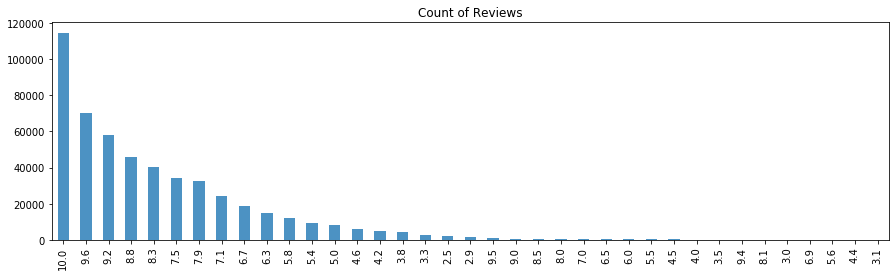

In [0]:
# checking distribution of review score
review_data.Reviewer_Score.value_counts().plot(kind='bar', title='Count of Reviews', figsize = (15, 4), alpha = 0.8)

In [0]:
# Rounding the Review Score to nearest integer
review_data['round_review_score'] = review_data.Reviewer_Score.apply(lambda x: np.ceil(x))

In [0]:
# Selecting subset of data for speedup the computation.
reviews_df = review_data.sample(frac = 0.1, replace = False, random_state=45)
reviews_df.head()

Before subseting, data size: (509202, 20)
After subseting, data size: (50920, 13)


,Hotel_Name,Positive_Review,Negative_Review,Average_Score,Reviewer_Score,Reviewer_Nationality,Tags,lat,lng,city_1,state,reviews,round_review_score
394165,Hotel Grums Barcelona,Large room close to th city perfect breakfast,No Negative,8.3,9.2,Germany,"[' Leisure trip ', ' Couple ', ' Comfort Doubl...",41.372784,2.172113,Sants-Montjuic,Catalonia,Large room close to th city perfect breakfast...,10.0
280308,H10 Itaca,Swimming pool,Noisy not in Eixample but near Sants station ...,8.2,6.3,Netherlands,"[' Leisure trip ', ' Couple ', ' Double or Twi...",41.381031,2.145552,Ciutat Vella,Catalonia,Swimming pool Noisy not in Eixample but near...,7.0
287039,Hotel Alimara,Pleasant staff good wifi good value for money,Quite far away from the city center Hotel is ...,8.1,7.9,Slovakia,"[' Leisure trip ', ' Couple ', ' Double or Twi...",41.433756,2.147327,London,England,Pleasant staff good wifi good value for money...,8.0
490682,Hotel Spadari Al Duomo,Great service great location beautifully put ...,nothing I can think of,9.3,9.6,United States of America,"[' Leisure trip ', ' Solo traveler ', ' Classi...",45.463579,9.186909,Novate Milanese,Lombardy,Great service great location beautifully put ...,10.0
129985,Le Pavillon de la Reine Spa,The location was fantastic I also like the fa...,The breakfast which was very expensive could ...,9.2,10.0,Switzerland,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",48.856272,2.366041,Paris,Ile-de-France,The location was fantastic I also like the fa...,10.0


In [0]:
nlp = spacy.load('en')

f1 = lambda x: str(x)
f2 = lambda x: x.lower()
f3 = lambda x: re.sub('[^\s][\]+[^\s]*', "", x)
f4 = lambda x: re.sub(r'\([^)]*\)', '', x)

text_regexes = lambda x: f4(f3(f2(f1(x))))

text_process_operators_list = [
    text_regexes,
    strip_tags,
    strip_punctuation,
    strip_non_alphanum,
    strip_numeric,
    remove_stopwords,
    strip_multiple_whitespaces
]


def text_preprocess(docs, logging=True):
    docs = [
            preprocess_string(
                text, 
                text_process_operators_list
            ) for text in docs
            ]
    
    texts_out = []
    for doc in docs:
        doc = nlp((" ".join(doc)),  
                  disable=['ner', 
                           'tagger', 
                           'textcat',])
        texts_out.append([tok.lemma_ for tok in doc if tok.lemma_ != '-PRON-'])
    return pd.Series(texts_out)

text_preprocess(reviews_df.reviews.iloc[10:15])

0    [lovely, old, hotel, well, european, hotel, aw...
1     [lady, reception, beauty, personality, negative]
2      [location, excellent, size, room, small, photo]
3    [great, location, good, restaurant, sofa, bed,...
4    [service, great, reception, personnel, helpful...
dtype: object

In [0]:
%time train_corpus = text_preprocess(reviews_df.reviews)

CPU times: user 2min 3s, sys: 1.48 s, total: 2min 5s
Wall time: 2min 5s


In [0]:
# create ngrams
ngram_phraser= models.Phrases(train_corpus, threshold=1)
ngram = models.phrases.Phraser(ngram_phraser_1)
# apply n-gram model to corpus
texts_1 = [ngram[token] for token in train_corpus]
# adding it to dataframe
texts_1 = [' '.join(text) for text in texts_1]
reviews_df['ngram'] = texts_1
reviews_df.head()

['large_room', 'close_city', 'perfect', 'breakfast', 'negative']
['large', 'room', 'close', 'city', 'perfect', 'breakfast', 'negative']


,Hotel_Name,Positive_Review,Negative_Review,Average_Score,Reviewer_Score,Reviewer_Nationality,Tags,lat,lng,city_1,state,reviews,round_review_score,ngram_1,ngram_2
394165,Hotel Grums Barcelona,Large room close to th city perfect breakfast,No Negative,8.3,9.2,Germany,"[' Leisure trip ', ' Couple ', ' Comfort Doubl...",41.372784,2.172113,Sants-Montjuic,Catalonia,Large room close to th city perfect breakfast...,10.0,large_room close_city perfect breakfast negative,large room close city perfect breakfast negative
280308,H10 Itaca,Swimming pool,Noisy not in Eixample but near Sants station ...,8.2,6.3,Netherlands,"[' Leisure trip ', ' Couple ', ' Double or Twi...",41.381031,2.145552,Ciutat Vella,Catalonia,Swimming pool Noisy not in Eixample but near...,7.0,swim_pool noisy eixample near sants_station ba...,swim_pool noisy eixample near sants_station ba...
287039,Hotel Alimara,Pleasant staff good wifi good value for money,Quite far away from the city center Hotel is ...,8.1,7.9,Slovakia,"[' Leisure trip ', ' Couple ', ' Double or Twi...",41.433756,2.147327,London,England,Pleasant staff good wifi good value for money...,8.0,pleasant_staff good_wifi good_value money far_...,pleasant staff good wifi good value_money far_...
490682,Hotel Spadari Al Duomo,Great service great location beautifully put ...,nothing I can think of,9.3,9.6,United States of America,"[' Leisure trip ', ' Solo traveler ', ' Classi...",45.463579,9.186909,Novate Milanese,Lombardy,Great service great location beautifully put ...,10.0,great service great_location beautifully think,great service great location beautifully think
129985,Le Pavillon de la Reine Spa,The location was fantastic I also like the fa...,The breakfast which was very expensive could ...,9.2,10.0,Switzerland,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",48.856272,2.366041,Paris,Ile-de-France,The location was fantastic I also like the fa...,10.0,location_fantastic like_fact central_quiet bre...,location fantastic like_fact central quiet bre...


In [0]:
def createLabelsFromReviewPoints(df):         #this function creates a new column which will be our classification label like low,medium high
    df['class']= df.apply (lambda row: label_reviews(row), axis=1)
    return df

In [0]:
def label_reviews(row):
    review = row['Reviewer_Score']
    if(review <=5  and review >= 0):
        return 1
    if(review <=7 and review > 5):
        return 2
    if(review <=8 and review > 7):
        return 3
    if(review <= 9 and review > 8):
        return 4 
    if(review > 9):
        return 5
    else:
        return 0

In [0]:
reviews_df = createLabelsFromReviewPoints(reviews_df)

In [0]:
# Dividing data by class
class_count = reviews_df['class'].value_counts().values

df_class_5 = reviews_df[reviews_df['class'] == 5.0]
df_class_4 = reviews_df[reviews_df['class'] == 4.0]
df_class_3 = reviews_df[reviews_df['class'] == 3.0]
df_class_2 = reviews_df[reviews_df['class'] == 2.0]
df_class_1 = reviews_df[reviews_df['class'] == 1.0]

df_class_5 = df_class_5.sample(class_count[0], replace=True)
df_class_4 = df_class_4.sample(class_count[0], replace=True)
df_class_3 = df_class_3.sample(class_count[0], replace=True)
df_class_2 = df_class_2.sample(class_count[0], replace=True)
df_class_1 = df_class_1.sample(class_count[0], replace=True)


# concatenate individual datafram
df_train = pd.concat([df_class_5, df_class_4, df_class_3, df_class_2, df_class_1], axis=0)
# df_train['class'].value_counts().plot(kind='bar', title='Before sampling Review distribution', ax = ax2)

In [0]:
# represent features in countvectorizer for ngram
vectorizer = CountVectorizer()
vectorizer.fit(df_train_oversampled.ngram)

# split into test and train sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_train, df_train['class'], test_size=0.4)


In [0]:
def onehot(train,test,col_name):
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(X_train_1[[col_name]])
    train_enc_df = pd.DataFrame (encoder.transform(X_train_1[[col_name]]).toarray())
    train_enc_df.columns = encoder.get_feature_names([col_name])
    train_enc_df = train_enc_df.drop([train_enc_df.columns[0]],axis=1)
    test_enc_df = pd.DataFrame (encoder.transform(X_test_1[[col_name]]).toarray())
    test_enc_df.columns = encoder.get_feature_names([col_name])
    test_enc_df = test_enc_df.drop([test_enc_df.columns[0]],axis=1)
    return train_enc_df, test_enc_df

In [0]:
def Build_matrix_idf_normalize(df,voc):
    '''Step3 -Build the Matrix with filter < 3 letters'''
    mat = build_matrix(df,voc)
    csr_info(mat)

    '''Step4 - Normalize the Matrix without inverse document frequency'''
    # mat2 = csr_idf(mat, copy=True)
    # mat3 = csr_l2normalize(mat, copy=True)
    return mat

In [0]:
#Create a sparse matrix

def build_matrix(df,idx):
    r""" Build sparse matrix from a list of documents, 
    each of which is a list of word/terms in the document.  
    """
    nrows = df.shape[0]
    ncols = len(idx)
    
    nnz = 0
    for index, row in df.iterrows():
      rowValue = row['Tags'].strip("'<>() ").replace('\'', '\"')
      rowValueToList = json.loads(rowValue)

      tagsList = []

      for tags in rowValueToList:
        tags = tags.strip()
        tagsList += tags
      nnz += len(set(tagsList))
        
    # set up memory
    ind = np.zeros(nnz, dtype=np.int)
    val = np.zeros(nnz, dtype=np.double)
    ptr = np.zeros(nrows+1, dtype=np.int)
    i = 0  # document ID / row counter
    n = 0  # non-zero counter
    # transfer values
    for index, row in df.iterrows():
      rowValue = row['Tags'].strip("'<>() ").replace('\'', '\"')
      rowValueToList = json.loads(rowValue)

      tagsList = []

      for tags in rowValueToList:
        tags = tags.strip()

        for tag  in tags.split():
          tag = porter.stem(tag)      #Stem the tag
          if tag in idx:     #Remove the stopwords
            if len(tag) > 2: 
              tagsList.append(tag)

      cnt = Counter(tagsList)
      keys = list(k for k,_ in cnt.most_common())
      l = len(keys)
      for j,k in enumerate(keys):
          if(k in idx):
              ind[j+n] = idx[k]
              val[j+n] = cnt[k]
          # else:
          #     print("Vocabulary Not Found",k)
      ptr[i+1] = ptr[i] + l
      n += l
      i += 1
            
    mat = csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.double)
    mat.sort_indices()
    return mat


def csr_info(mat, name="", non_empy=False):
    r""" Print out info about this CSR matrix. If non_empy, 
    report number of non-empty rows and cols as well
    """
    if non_empy:
        print("%s [nrows %d (%d non-empty), ncols %d (%d non-empty), nnz %d]" % (
                name, mat.shape[0], 
                sum(1 if mat.indptr[i+1] > mat.indptr[i] else 0 
                for i in range(mat.shape[0])), 
                mat.shape[1], len(np.unique(mat.indices)), 
                len(mat.data)))
    else:
        print( "%s [nrows %d, ncols %d, nnz %d]" % (name, 
                mat.shape[0], mat.shape[1], len(mat.data)) )

In [0]:
def convertTagsToFeatures(df):
  features = {}
  tid = 0
  for index, row in df.iterrows():
    rowValue = row['Tags'].strip("'<>() ").replace('\'', '\"')
    rowValuve = re.sub(r"\b\d+\b", "", rowValue)
    rowValueToList = json.loads(rowValue)
    for tags in rowValueToList:
      tags = tags.strip()
      #tags = check(tags)
      for tag  in tags.split():
        #tag = spell.correction(tag)  #Correct the spellings
        tag = porter.stem(tag)        #Stem the tag
        if not tag in stop_words:     #Remove the stopwords
          if len(tag) > 2:            #Remove the words that that less than or equal to 2
            if tag not in features:
                features[tag] = tid
                tid += 1
  return features

In [0]:
#Features from tags
tagFeatures = convertTagsToFeatures(X_train_1)
tags_csr = Build_matrix_idf_normalize(X_train_1,tagFeatures)
tags_csr_test = Build_matrix_idf_normalize(X_test_1,tagFeatures)

 [nrows 73107, ncols 374, nnz 757684]
 [nrows 48738, ncols 374, nnz 505539]


In [0]:
#One hot encode
train_nation_df,test_nation_df = onehot(X_train_1,X_test_1,'Reviewer_Nationality')
train_hotel_df,test_hotel_df = onehot(X_train_1,X_test_1,'Hotel_Name')

train_city_df,test_city_df = onehot(X_train_1,X_test_1,'city_1')
train_state_df,test_state_df = onehot(X_train_1,X_test_1,'state')

In [0]:
def convertToCSR(df):
    return scipy.sparse.csr_matrix(df.values)

In [0]:
#DataFrame to Sparse Matrix
train_nation_csr = convertToCSR(train_nation_df)
test_nation_csr = convertToCSR(test_nation_df)

train_hotel_csr = convertToCSR(train_hotel_df)
test_hotel_csr = convertToCSR(test_hotel_df)

train_city_csr = convertToCSR(train_city_df)
test_city_csr = convertToCSR(test_city_df)

train_state_csr = convertToCSR(train_state_df)
test_state_csr = convertToCSR(test_state_df)

In [0]:
def concatVectorizer(m1, m2):
    return hstack((m1, m2))

In [0]:
#Concat all CSR train data
X_train_csr = concatVectorizer(concatVectorizer(train_nation_csr, train_hotel_csr), vectorizer_1.transform(X_train_1.ngram))

In [0]:
#Concat all CSR test data

X_test_csr = concatVectorizer(concatVectorizer(test_nation_csr, test_hotel_csr), vectorizer_1.transform(X_test_1.ngram))

# **PCA**

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

In [0]:
# scaler = StandardScaler(with_mean=False)
# # Fit on training set only.
# scaler.fit(X_train_csr)
# # Apply transform to both the training set and the test set.
# X_train_csr = scaler.transform(X_train_csr)
# X_test_csr = scaler.transform(X_test_csr)


# pca = TruncatedSVD(0.96)
# X_train_csr = pca.fit_transform(X_train_csr)
# X_test_csr = pca.transform(X_test_csr)

In [0]:
def predict_random_forest():
    model = RandomForestClassifier(n_estimators=150, bootstrap = True, max_features = 'sqrt',n_jobs=-1)
    model.fit(X_train_csr, y_train_1)
    y_pred_random = model.predict(X_test_csr)
    print(classification_report(y_test_1, y_pred_random))
    print("RMSE for Neural Random Forest Classifier",sqrt(mean_squared_error(y_test_1, y_pred_random)))

In [0]:
def predict_Neural():
    clf = MLPClassifier(hidden_layer_sizes=(50,100), max_iter=200,activation = 'logistic',solver='adam',learning_rate_init=0.0001,learning_rate='adaptive')
    clf.fit(X_train_csr, y_train_1)
    y_pred_neural = clf.predict(X_test_csr)
    print(classification_report(y_test_1, y_pred_neural))
    print("RMSE for Neural MLP Classifier",sqrt(mean_squared_error(y_test_1, y_pred_neural)))

In [0]:
def predict_GaussianNB():
    gnb = GaussianNB()
    gnb.fit(X_train_csr.todense(), y_train_1)
    y_pred_GB = gnb.predict(X_test_csr.todense()) 
    print(classification_report(y_test_1, y_pred_GB))
    print("RMSE for Neural Random Naive Classifier",sqrt(mean_squared_error(y_test_1, y_pred_GB)))

In [0]:
def predict_SVM():
    svclassifier = LinearSVR(random_state=50, max_iter=100000, epsilon=0, tol=1e-9)
    svclassifier.fit(X_train_csr.todense(), y_train_1)
    scv_test_predict = svclassifier.predict(X_test_csr.todense())
    print(scv_test_predict)
    print(classification_report(y_test_1, np.rint(scv_test_predict)))
    print("RMSE for Neural Random SVR Classifier",sqrt(mean_squared_error(y_test_1, np.rint(scv_test_predict))))

In [0]:
predict_random_forest()

              precision    recall  f1-score   support

           1       0.97      0.99      0.98      9679
           2       0.94      0.95      0.94      9702
           3       0.88      0.85      0.86      9804
           4       0.91      0.84      0.87      9838
           5       0.81      0.88      0.85      9715

    accuracy                           0.90     48738
   macro avg       0.90      0.90      0.90     48738
weighted avg       0.90      0.90      0.90     48738



In [0]:
predict_Neural()

              precision    recall  f1-score   support

           1       0.20      1.00      0.33      9679
           2       0.00      0.00      0.00      9702
           3       0.00      0.00      0.00      9804
           4       0.00      0.00      0.00      9838
           5       0.00      0.00      0.00      9715

    accuracy                           0.20     48738
   macro avg       0.04      0.20      0.07     48738
weighted avg       0.04      0.20      0.07     48738



In [0]:
predict_GaussianNB()

              precision    recall  f1-score   support

           1       0.42      1.00      0.59      9679
           2       0.49      0.59      0.54      9702
           3       0.70      0.32      0.44      9804
           4       0.58      0.43      0.49      9838
           5       0.85      0.21      0.33      9715

    accuracy                           0.51     48738
   macro avg       0.61      0.51      0.48     48738
weighted avg       0.61      0.51      0.48     48738



In [0]:
predict_SVM()

[4.30712489 3.91442066 2.49796474 ... 2.9547812  3.         4.        ]
              precision    recall  f1-score   support

        -4.0       0.00      0.00      0.00         0
        -3.0       0.00      0.00      0.00         0
        -2.0       0.00      0.00      0.00         0
        -1.0       0.00      0.00      0.00         0
        -0.0       0.00      0.00      0.00         0
         1.0       0.91      0.73      0.81      9679
         2.0       0.66      0.71      0.68      9702
         3.0       0.50      0.63      0.56      9804
         4.0       0.53      0.64      0.58      9838
         5.0       0.75      0.38      0.50      9715
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.00      0.00      0.00         0
         9.0       0.00      0.00      0.00         0
        10.0       0.00      0.00      0.00         0
        11.0       0.00      0.00      0.00         0
        1